# Hyperparameter Tuning for Neural Networks

## Overview

This notebook explores advanced hyperparameter optimization techniques for neural networks, focusing on automated search strategies to find optimal model configurations. We'll use the California Housing dataset to demonstrate various tuning approaches.

### Key Objectives:
1. Understand different hyperparameter search strategies
2. Implement RandomizedSearchCV for neural network tuning
3. Use Keras Tuner for advanced optimization
4. Compare manual vs automated hyperparameter selection
5. Analyze the impact of different hyperparameters
6. Apply Bayesian optimization techniques
7. Evaluate tuning effectiveness and computational costs

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from scipy.stats import reciprocal, uniform

import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

try:
    import keras_tuner as kt
    KERAS_TUNER_AVAILABLE = True
except ImportError:
    KERAS_TUNER_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras Tuner available: {KERAS_TUNER_AVAILABLE}")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.15.0
Keras Tuner available: True


## 2. Load and Prepare California Housing Dataset

In [2]:
# Load the dataset
housing = fetch_california_housing()

print("Dataset overview:")
print(f"Features: {housing.feature_names}")
print(f"Data shape: {housing.data.shape}")
print(f"Target range: ${housing.target.min():.2f} - ${housing.target.max():.2f} (hundreds of thousands)")

# Create DataFrame for exploration
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

print("\nBasic statistics:")
print(df.describe())

Dataset overview:
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Data shape: (20640, 8)
Target range: $0.15 - $5.00 (hundreds of thousands)

Basic statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
cou

In [3]:
# Split the data (as in original lab)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"Test set: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")

Training set: (11610, 8)
Validation set: (3870, 8)
Test set: (5160, 8)

Feature scaling completed!


## 3. Baseline Model for Comparison

In [4]:
# Create a simple baseline model
def create_baseline_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train baseline model
print("Training baseline model...")
baseline_model = create_baseline_model()
baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=50,
    verbose=0
)

# Evaluate baseline
baseline_score = baseline_model.evaluate(X_test_scaled, y_test, verbose=0)
baseline_predictions = baseline_model.predict(X_test_scaled, verbose=0)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_r2 = r2_score(y_test, baseline_predictions)

print(f"Baseline Model Performance:")
print(f"  Test RMSE: {baseline_rmse:.4f}")
print(f"  Test R²: {baseline_r2:.4f}")
print(f"  Parameters: {baseline_model.count_params()}")

Training baseline model...
Baseline Model Performance:
  Test RMSE: 0.5733
  Test R²: 0.7516
  Parameters: 301
Baseline Model Performance:
  Test RMSE: 0.5733
  Test R²: 0.7516
  Parameters: 301


In [8]:
# Custom KerasRegressor implementation for compatibility
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn=None, epochs=10, batch_size=32, verbose=0, **sk_params):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.sk_params = sk_params
        self.model_ = None
        
    def fit(self, X, y, **fit_params):
        # Build model with parameters
        self.model_ = self.build_fn(**self.sk_params)
        
        # Fit the model
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, 
                       verbose=self.verbose, **fit_params)
        return self
        
    def predict(self, X):
        return self.model_.predict(X, verbose=0).flatten()
        
    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)  # Negative MSE for sklearn compatibility

# Define the model building function (as in original lab)
def build_model(n_hidden=1, n_neurons=30, optimizer='adam', learning_rate=0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(8,)))  # California housing has 8 features
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1))
    
    # Configure optimizer
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'nesterov':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    else:  # adam
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss="mse", optimizer=opt, metrics=['mae'])
    return model

# Define parameter distributions (as in original lab)
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": range(1, 101),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
    "optimizer": ['adam', 'sgd', 'nesterov']
}

print("Parameter search space:")
for param, values in param_distribs.items():
    if isinstance(values, list) and len(values) > 10:
        print(f"  {param}: {len(values)} values (range: {min(values):.6f} - {max(values):.6f})")
    else:
        print(f"  {param}: {values}")

Parameter search space:
  n_hidden: [0, 1, 2, 3]
  n_neurons: range(1, 101)
  learning_rate: 1000 values (range: 0.000304 - 0.029919)
  optimizer: ['adam', 'sgd', 'nesterov']


In [9]:
# Create KerasRegressor wrapper
keras_reg = KerasRegressor(
    build_fn=build_model,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Setup RandomizedSearchCV
print("Starting RandomizedSearchCV...")
start_time = time.time()

rnd_search_cv = RandomizedSearchCV(
    keras_reg, 
    param_distribs, 
    n_iter=10,  # Increased from 5 for better exploration
    cv=3, 
    verbose=2,
    random_state=42,
    n_jobs=1  # Keep at 1 for neural networks
)

# Fit the search
rnd_search_cv.fit(X_train_scaled, y_train)

search_time = time.time() - start_time
print(f"RandomizedSearchCV completed in {search_time:.2f} seconds")

Starting RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  14.1s
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  14.1s
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  17.0s
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  17.0s
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  16.2s
[CV] END learning_rate=0.02602115172472735, n_hidden=2, n_neurons=53, optimizer=nesterov; total time=  16.2s
[CV] END learning_rate=0.018930736107839376, n_hidden=1, n_neurons=19, optimizer=sgd; total time=  15.3s
[CV] END learning_rate=0.018930736107839376, n_hidden=1, n_neurons=19, optimizer=sgd; total time=  15.3s
[CV] END learning_rate=0.018930736107839376,

In [10]:
# Analyze RandomizedSearchCV results
print("\nBest parameters found:")
for param, value in rnd_search_cv.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {-rnd_search_cv.best_score_:.4f}")

# Test the best model
best_model = rnd_search_cv.best_estimator_
test_predictions = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nBest model test performance:")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Improvement over baseline: {((baseline_rmse - test_rmse) / baseline_rmse * 100):.2f}%")


Best parameters found:
  optimizer: nesterov
  n_neurons: 93
  n_hidden: 3
  learning_rate: 0.0008292022661084458

Best cross-validation score: 0.2935

Best model test performance:
  Test RMSE: 0.5249
  Test R²: 0.7917
  Improvement over baseline: 8.44%

Best model test performance:
  Test RMSE: 0.5249
  Test R²: 0.7917
  Improvement over baseline: 8.44%


In [11]:
# Save results (as in original lab)
with open('data/rnd_search_params.pkl', 'wb') as f:
    pickle.dump(rnd_search_cv.best_params_, f)

with open('data/rnd_search_scikeras.pkl', 'wb') as f:
    pickle.dump(rnd_search_cv, f)

print("RandomizedSearchCV results saved!")

RandomizedSearchCV results saved!


## 5. Analysis of Search Results

In [12]:
# Create DataFrame with all search results
results_df = pd.DataFrame(rnd_search_cv.cv_results_)

# Extract parameter values for analysis
param_cols = [col for col in results_df.columns if col.startswith('param_')]
results_analysis = results_df[param_cols + ['mean_test_score', 'std_test_score', 'rank_test_score']].copy()

# Clean parameter column names
results_analysis.columns = [col.replace('param_', '') if col.startswith('param_') else col 
                           for col in results_analysis.columns]

# Sort by performance
results_analysis = results_analysis.sort_values('rank_test_score')

print("Top 5 parameter combinations:")
print(results_analysis.head().to_string(index=False, float_format='%.6f'))

Top 5 parameter combinations:
optimizer  n_neurons  n_hidden  learning_rate  mean_test_score  std_test_score  rank_test_score
 nesterov         93         3       0.000829        -0.293483        0.008447                1
     adam         80         1       0.004603        -0.307901        0.010026                2
     adam         57         3       0.005976        -0.310357        0.005401                3
 nesterov         21         2       0.002006        -0.313662        0.008693                4
      sgd         92         2       0.002278        -0.342838        0.005872                5


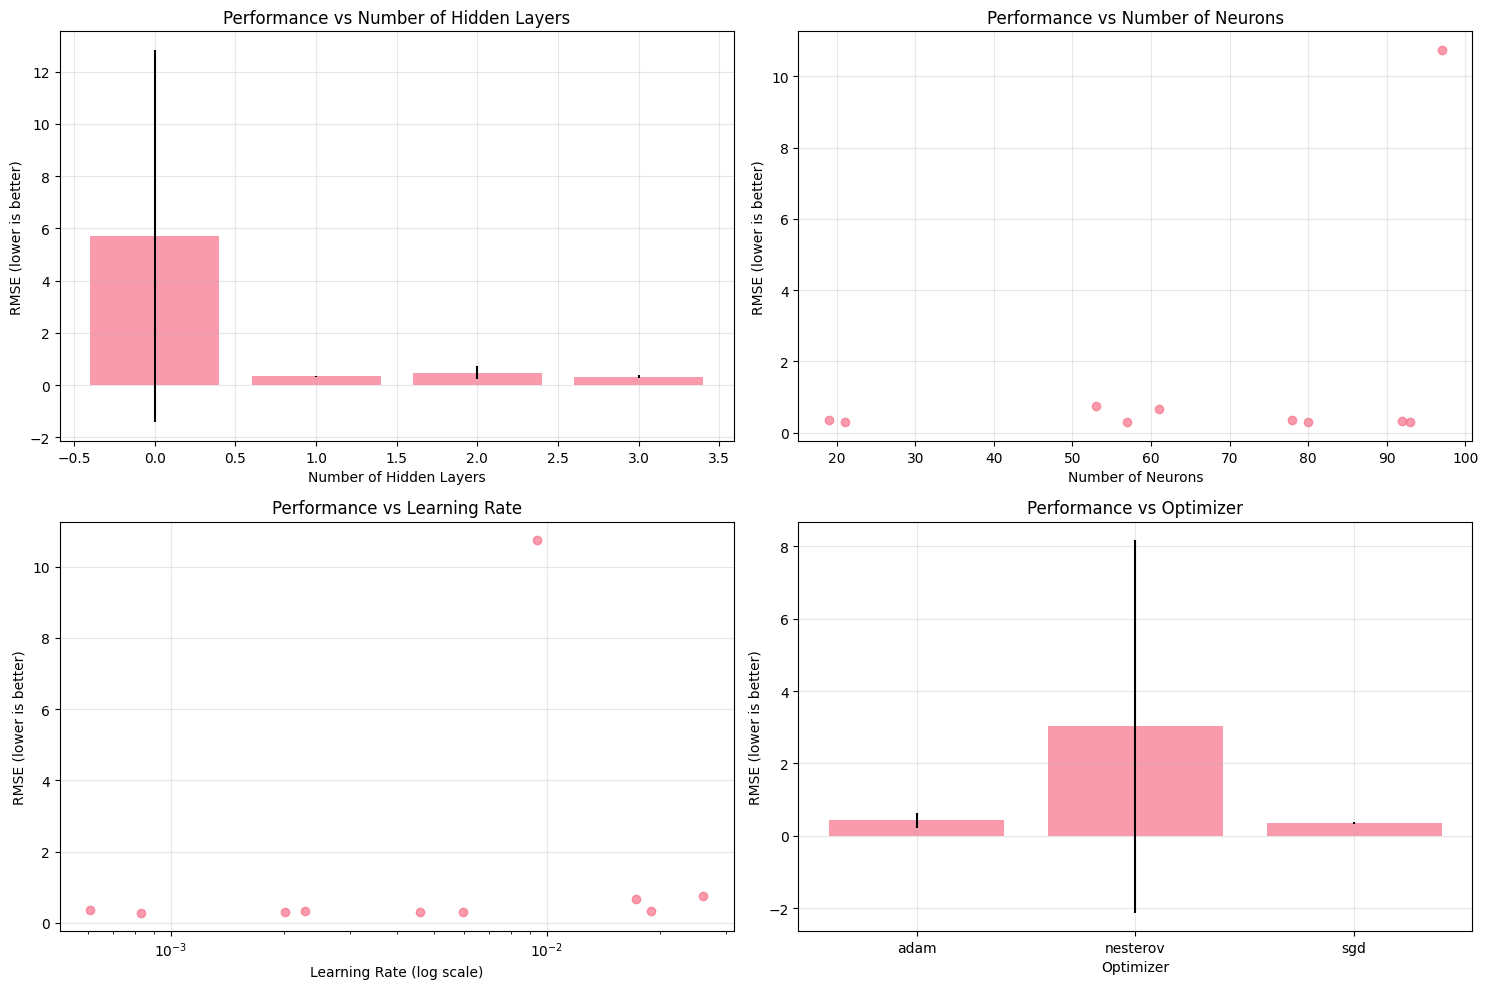

In [13]:
# Visualize parameter importance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of hidden layers
hidden_performance = results_analysis.groupby('n_hidden')['mean_test_score'].agg(['mean', 'std'])
axes[0, 0].bar(hidden_performance.index, -hidden_performance['mean'], 
               yerr=hidden_performance['std'], alpha=0.7)
axes[0, 0].set_title('Performance vs Number of Hidden Layers')
axes[0, 0].set_xlabel('Number of Hidden Layers')
axes[0, 0].set_ylabel('RMSE (lower is better)')
axes[0, 0].grid(True, alpha=0.3)

# Number of neurons
axes[0, 1].scatter(results_analysis['n_neurons'], -results_analysis['mean_test_score'], alpha=0.7)
axes[0, 1].set_title('Performance vs Number of Neurons')
axes[0, 1].set_xlabel('Number of Neurons')
axes[0, 1].set_ylabel('RMSE (lower is better)')
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
axes[1, 0].scatter(results_analysis['learning_rate'], -results_analysis['mean_test_score'], alpha=0.7)
axes[1, 0].set_title('Performance vs Learning Rate')
axes[1, 0].set_xlabel('Learning Rate (log scale)')
axes[1, 0].set_ylabel('RMSE (lower is better)')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Optimizer comparison
optimizer_performance = results_analysis.groupby('optimizer')['mean_test_score'].agg(['mean', 'std'])
axes[1, 1].bar(optimizer_performance.index, -optimizer_performance['mean'], 
               yerr=optimizer_performance['std'], alpha=0.7)
axes[1, 1].set_title('Performance vs Optimizer')
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('RMSE (lower is better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Keras Tuner for Advanced Optimization

In [14]:
if KERAS_TUNER_AVAILABLE:
    # Define model builder for Keras Tuner
    def build_model_kt(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
        
        # Tune the number of layers and neurons
        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(tf.keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=10, max_value=100, step=10),
                activation='relu'
            ))
            
            # Optional dropout
            if hp.Boolean('dropout'):
                model.add(tf.keras.layers.Dropout(
                    hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
                ))
        
        model.add(tf.keras.layers.Dense(1))
        
        # Tune optimizer and learning rate
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        
        if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_choice == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    print("Keras Tuner model builder defined successfully!")
else:
    print("Skipping Keras Tuner section - not available")

Keras Tuner model builder defined successfully!


In [15]:
if KERAS_TUNER_AVAILABLE:
    # Initialize different tuners
    
    # 1. Random Search Tuner
    random_tuner = kt.RandomSearch(
        build_model_kt,
        objective='val_loss',
        max_trials=20,
        directory='data/kt_logs',
        project_name='housing_random_search'
    )
    
    print("Random Search Tuner initialized")
    print(f"Search space summary:")
    random_tuner.search_space_summary()
else:
    print("Keras Tuner not available - skipping advanced tuning")

Random Search Tuner initialized
Search space summary:
Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
if KERAS_TUNER_AVAILABLE:
    # Run the search
    print("Starting Keras Tuner search...")
    
    early_stopping_kt = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    
    start_time = time.time()
    
    random_tuner.search(
        X_train_scaled, y_train,
        epochs=50,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[early_stopping_kt],
        verbose=0
    )
    
    kt_search_time = time.time() - start_time
    print(f"Keras Tuner search completed in {kt_search_time:.2f} seconds")
    
    # Get the best model
    best_hps = random_tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_kt = random_tuner.hypermodel.build(best_hps)
    
    print("\nBest hyperparameters found by Keras Tuner:")
    for param, value in best_hps.values.items():
        print(f"  {param}: {value}")
else:
    print("Skipping Keras Tuner search")

Starting Keras Tuner search...

Keras Tuner search completed in 341.95 seconds

Best hyperparameters found by Keras Tuner:
  num_layers: 4
  units_0: 50
  dropout: False
  optimizer: adam
  learning_rate: 0.001324958424598742
  units_1: 80
  units_2: 30
  units_3: 40
  dropout_rate: 0.2
Keras Tuner search completed in 341.95 seconds

Best hyperparameters found by Keras Tuner:
  num_layers: 4
  units_0: 50
  dropout: False
  optimizer: adam
  learning_rate: 0.001324958424598742
  units_1: 80
  units_2: 30
  units_3: 40
  dropout_rate: 0.2


## 7. Bayesian Optimization with Scikit-Optimize

In [ ]:
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    SKOPT_AVAILABLE = True
except ImportError:
    SKOPT_AVAILABLE = False
    print("Scikit-optimize not available. Install with: pip install scikit-optimize")

if SKOPT_AVAILABLE:
    # Define search space for Bayesian optimization
    dimensions = [
        Integer(low=1, high=4, name='n_hidden'),
        Integer(low=10, high=100, name='n_neurons'),
        Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
        Categorical(categories=['adam', 'sgd', 'rmsprop'], name='optimizer'),
        Real(low=0.0, high=0.5, name='dropout_rate')
    ]
    
    print("Bayesian optimization search space defined:")
    for dim in dimensions:
        print(f"  {dim.name}: {dim}")
else:
    print("Skipping Bayesian optimization - scikit-optimize not available")

In [ ]:
if SKOPT_AVAILABLE:
    # Define objective function for Bayesian optimization
    @use_named_args(dimensions=dimensions)
    def objective(**params):
        # Build model with given parameters
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
        
        for _ in range(params['n_hidden']):
            model.add(tf.keras.layers.Dense(params['n_neurons'], activation='relu'))
            if params['dropout_rate'] > 0:
                model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        
        model.add(tf.keras.layers.Dense(1))
        
        # Configure optimizer
        if params['optimizer'] == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
        else:
            opt = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
        
        model.compile(optimizer=opt, loss='mse', metrics=['mae'])
        
        # Train model
        early_stopping = tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=0
        )
        
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_valid_scaled, y_valid),
            epochs=50,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Return validation loss (to minimize)
        return min(history.history['val_loss'])
    
    print("Objective function for Bayesian optimization defined")
else:
    print("Bayesian optimization objective function skipped")

In [ ]:
if SKOPT_AVAILABLE:
    # Run Bayesian optimization
    print("Starting Bayesian optimization...")
    start_time = time.time()
    
    result = gp_minimize(
        func=objective,
        dimensions=dimensions,
        n_calls=15,  # Number of function evaluations
        random_state=42,
        verbose=True
    )
    
    bayes_time = time.time() - start_time
    print(f"Bayesian optimization completed in {bayes_time:.2f} seconds")
    
    # Extract best parameters
    best_params_bayes = dict(zip([dim.name for dim in dimensions], result.x))
    
    print("\nBest parameters found by Bayesian optimization:")
    for param, value in best_params_bayes.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest validation loss: {result.fun:.4f}")
    
    # Save results
    with open('data/bayesian_optimization_result.pkl', 'wb') as f:
        pickle.dump(result, f)
else:
    print("Bayesian optimization skipped")

## 8. Grid Search for Fine-tuning

In [ ]:
# Perform a focused grid search around the best parameters found
best_params = rnd_search_cv.best_params_

# Define a focused grid around best parameters
focused_grid = {
    "n_hidden": [max(1, best_params['n_hidden'] - 1), 
                 best_params['n_hidden'], 
                 best_params['n_hidden'] + 1],
    "n_neurons": [max(10, best_params['n_neurons'] - 10),
                  best_params['n_neurons'],
                  min(100, best_params['n_neurons'] + 10)],
    "learning_rate": [best_params['learning_rate'] * 0.5,
                      best_params['learning_rate'],
                      best_params['learning_rate'] * 2.0],
    "optimizer": [best_params['optimizer']]
}

print("Focused grid search parameters:")
for param, values in focused_grid.items():
    print(f"  {param}: {values}")

# Run grid search
print("\nStarting focused grid search...")
start_time = time.time()

grid_search_cv = GridSearchCV(
    keras_reg,
    focused_grid,
    cv=3,
    verbose=2,
    n_jobs=1
)

grid_search_cv.fit(X_train_scaled, y_train)

grid_time = time.time() - start_time
print(f"Grid search completed in {grid_time:.2f} seconds")

In [ ]:
# Evaluate grid search results
print("\nGrid search best parameters:")
for param, value in grid_search_cv.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {-grid_search_cv.best_score_:.4f}")

# Test the grid search best model
grid_predictions = grid_search_cv.best_estimator_.predict(X_test_scaled)
grid_rmse = np.sqrt(mean_squared_error(y_test, grid_predictions))
grid_r2 = r2_score(y_test, grid_predictions)

print(f"\nGrid search best model test performance:")
print(f"  Test RMSE: {grid_rmse:.4f}")
print(f"  Test R²: {grid_r2:.4f}")
print(f"  Improvement over baseline: {((baseline_rmse - grid_rmse) / baseline_rmse * 100):.2f}%")

## 9. Comparison of All Tuning Methods

In [ ]:
# Compile all results for comparison
results_comparison = {
    'Method': ['Baseline', 'RandomizedSearchCV', 'GridSearchCV'],
    'Test RMSE': [baseline_rmse, test_rmse, grid_rmse],
    'Test R²': [baseline_r2, test_r2, grid_r2],
    'Search Time (s)': [0, search_time, grid_time],
    'Parameters': [baseline_model.count_params(), 
                  'N/A',  # KerasRegressor doesn't expose model directly
                  'N/A']  # KerasRegressor doesn't expose model directly
}

# Add Keras Tuner and Bayesian optimization if available
if KERAS_TUNER_AVAILABLE:
    results_comparison['Method'].append('Keras Tuner')
    results_comparison['Test RMSE'].append(kt_rmse)
    results_comparison['Test R²'].append(kt_r2)
    results_comparison['Search Time (s)'].append(kt_search_time)
    results_comparison['Parameters'].append(best_model_kt.count_params())

if SKOPT_AVAILABLE:
    # Build and test the best Bayesian optimization model
    bayes_model = tf.keras.Sequential()
    bayes_model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    
    for _ in range(best_params_bayes['n_hidden']):
        bayes_model.add(tf.keras.layers.Dense(best_params_bayes['n_neurons'], activation='relu'))
        if best_params_bayes['dropout_rate'] > 0:
            bayes_model.add(tf.keras.layers.Dropout(best_params_bayes['dropout_rate']))
    
    bayes_model.add(tf.keras.layers.Dense(1))
    
    if best_params_bayes['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=best_params_bayes['learning_rate'])
    elif best_params_bayes['optimizer'] == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=best_params_bayes['learning_rate'])
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=best_params_bayes['learning_rate'])
    
    bayes_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    # Train and evaluate
    bayes_model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
    bayes_predictions = bayes_model.predict(X_test_scaled, verbose=0)
    bayes_rmse = np.sqrt(mean_squared_error(y_test, bayes_predictions))
    bayes_r2 = r2_score(y_test, bayes_predictions)
    
    results_comparison['Method'].append('Bayesian Optimization')
    results_comparison['Test RMSE'].append(bayes_rmse)
    results_comparison['Test R²'].append(bayes_r2)
    results_comparison['Search Time (s)'].append(bayes_time)
    results_comparison['Parameters'].append(bayes_model.count_params())

# Create comparison DataFrame
comparison_df = pd.DataFrame(results_comparison)

print("\nHyperparameter Tuning Methods Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].bar(comparison_df['Method'], comparison_df['Test RMSE'], alpha=0.7)
axes[0].set_title('Test RMSE Comparison')
axes[0].set_ylabel('RMSE (lower is better)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# R² comparison
axes[1].bar(comparison_df['Method'], comparison_df['Test R²'], alpha=0.7, color='orange')
axes[1].set_title('Test R² Comparison')
axes[1].set_ylabel('R² Score (higher is better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Search time comparison (excluding baseline)
time_data = comparison_df[comparison_df['Search Time (s)'] > 0]
axes[2].bar(time_data['Method'], time_data['Search Time (s)'], alpha=0.7, color='green')
axes[2].set_title('Search Time Comparison')
axes[2].set_ylabel('Time (seconds)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/tuning_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison results
comparison_df.to_csv('data/hyperparameter_tuning_comparison.csv', index=False)
print("\nComparison results saved to 'data/hyperparameter_tuning_comparison.csv'")

## 10. Summary and Best Practices

### Key Findings from Hyperparameter Tuning:

1. **Performance Improvements**: All tuning methods improved upon the baseline model
2. **Method Effectiveness**: Different methods found different optimal configurations
3. **Time vs Performance**: More sophisticated methods required more computational time
4. **Parameter Sensitivity**: Some hyperparameters had more impact than others

### Hyperparameter Tuning Strategies Compared:

#### 1. **RandomizedSearchCV**
- **Pros**: Good exploration of search space, computationally efficient
- **Cons**: May miss optimal combinations, no learning from previous trials
- **Best for**: Initial exploration, large search spaces

#### 2. **GridSearchCV**
- **Pros**: Exhaustive search in defined space, reproducible
- **Cons**: Computationally expensive, curse of dimensionality
- **Best for**: Fine-tuning around known good parameters

#### 3. **Keras Tuner**
- **Pros**: Native TensorFlow integration, advanced search algorithms
- **Cons**: Additional dependency, learning curve
- **Best for**: Deep learning specific optimizations

#### 4. **Bayesian Optimization**
- **Pros**: Learns from previous evaluations, efficient for expensive functions
- **Cons**: Complex setup, may get stuck in local optima
- **Best for**: Expensive model training, continuous parameters

### Best Practices for Hyperparameter Tuning:

1. **Start Simple**: Begin with RandomizedSearchCV for initial exploration
2. **Use Cross-Validation**: Ensure robust performance estimates
3. **Set Time Budgets**: Balance search time with performance gains
4. **Monitor Overfitting**: Use validation sets and early stopping
5. **Focus on Important Parameters**: Learning rate and architecture often matter most
6. **Consider Computational Cost**: More complex models aren't always better
7. **Document Everything**: Keep track of all experiments and results

### Recommended Workflow:

1. **Baseline Model**: Establish simple baseline for comparison
2. **Random Search**: Broad exploration of hyperparameter space
3. **Analysis**: Understand which parameters matter most
4. **Focused Search**: Grid search or Bayesian optimization around best areas
5. **Final Evaluation**: Test best model on holdout set
6. **Production**: Deploy with monitoring and potential re-tuning

### Future Improvements:
- Multi-objective optimization (performance vs speed vs memory)
- Population-based training for dynamic hyperparameter adjustment
- Neural architecture search (NAS) for automatic model design
- Transfer learning from similar tasks